<a href="https://colab.research.google.com/github/Narang-Garima/Machine-Learning-Updated/blob/Projects/Kmeans_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KMeans – Unsupervised Clustering Algorithm

-Let the dataset have n data points, each with n features → shape: (n_rows, n_features)

-Initialize k centroids (either randomly or by selecting k points from the dataset) → shape: (k, n_features)

-Assign each point to the nearest centroid using Euclidean distance

-Update centroids by computing the mean of all points assigned to each cluster

-Repeat the assignment and update steps until centroids stop changing or a maximum number of iterations is reached (convergence)

-Return:

---Cluster labels for each point

---Final centroids

The algorithm is non-parametric: the only thing learned is the position of centroids

In [ ]:
from dataclasses import dataclass, field
import numpy as np
import math


## Kmeans from scratch

In [ ]:
@dataclass
class Kmeans:
  n_clusters: int
  max_iter: int =100
  init: str = 'random'
  tol_threshold: float = 1e-4                             # threshold for checking convergence
  centroids: np.ndarray = field(default=None, init=False) # init False, means they are not included in the constructor
  labels: np.ndarray = field(default=None, init=False)


  def init_centroids(self, X):
    if self.init =='random':
      # find a boundary box to choose centrid from within
      min_X = np.min(X, axis=0)
      max_X = np.max(X, axis=0)
      return np.random.uniform(low= min_X, high=max_X, size=(self.n_clusters, X.shape[1]))
    else:
      idx = np.random.choice(len(X), self.n_clusters,replace=False) # use index of the datapoints to make them centroid at init
      return X[idx,:]

  def distance_calc(self, X):
    X_sq = np.sum(X**2, axis=1).reshape(-1,1)
    c_sq = np.sum(self.centroids **2, axis =1)
    distances = X_sq + c_sq - 2 * np.dot(X, self.centroids.T)
    return distances

  def fit(self, X):
    # Step1: initialize centroids
    self.centroids = self.init_centroids(X)

    # iterate the process till max_iterations
    for _ in range(self.max_iter):

      # Step2: Calculate Eucleadian distance
      distances = self.distance_calc(X)
      labels = np.argmin(distances, axis=1) # provide cluster labels as per the distances calculated for each cluster

      # Step3 update centroids
      new_centroids =[]
      for i in range(self.n_clusters):
        cluster_pts= X[labels == i]
        if len(cluster_pts) > 0:
          new_centroids.append(np.mean(cluster_pts, axis=0))
        else:
          new_centroids.append(self.centroids[i]) # if empty cluster, keep the centroid position

      # convert new_centroids to array
      new_centroids = np.array(new_centroids)

      # step 4: check for convergence
      if np.linalg.norm(new_centroids - self.centroids) < self.tol_threshold:
        break
      self.centroids = new_centroids
    self.labels = labels
    return self.labels, self.centroids


  def predict(self, X):
    distances = self.distance_calc(X)
    return np.argmin(distances, axis=1)


In [ ]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Fitting and predicting on wine dataset

In [ ]:
# Load wine dataset
df = load_wine()
X = df.data

# Split into train/test
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# no of clusters
n_clusters = 3

# create object of Kmeans class
kmeans = Kmeans(n_clusters=n_clusters)

## Fit the model(made from scratch)

In [ ]:

# Scale the train features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# PCA train set to 3
pca = PCA(n_components =3)
X_train_3D = pca.fit_transform(X_train_scaled)

# Fit on reduced data
train_labels, centroids = kmeans.fit(X_train_3D)

## predict using model(made from scratch)

In [ ]:
# predict

# Scale test set
X_test_scaled = scaler.transform(X_test)
# PCA test set
X_test_3D = pca.transform(X_test_scaled)
# predict
test_labels  = kmeans.predict(X_test_3D)


## Visualization in 2D space

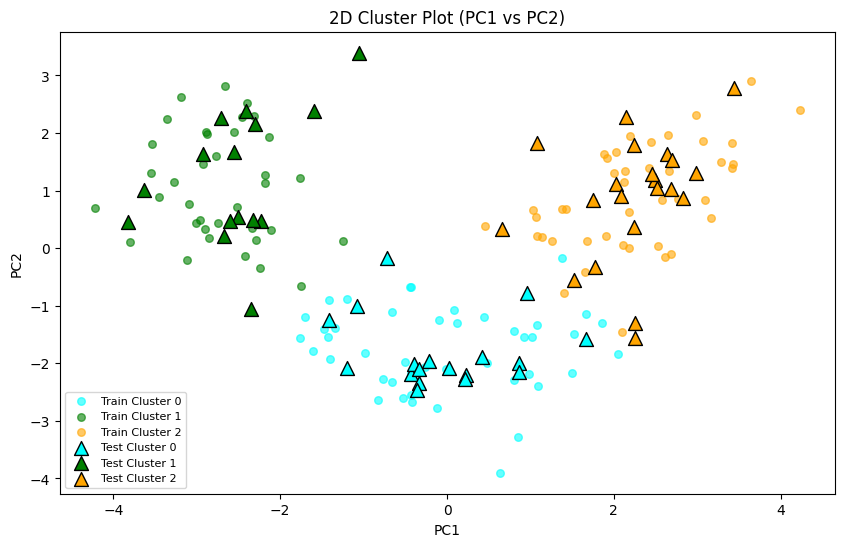

In [ ]:
# since we have 3 PCA, choosing 2 for 2D

# Use integer indices for the principal components
pc_x_index = 0
pc_y_index = 1

plt.figure(figsize=(10,6))

colors = ['cyan', 'green', 'orange']

# --- Plot training points ---
for cluster in range(kmeans.n_clusters):
    plt.scatter(
        X_train_3D[train_labels == cluster, pc_x_index],
        X_train_3D[train_labels == cluster, pc_y_index],
        color=colors[cluster],
        label=f"Train Cluster {cluster}",
        alpha=0.6,
        s=30
    )

# --- Plot test points ---
for cluster in range(kmeans.n_clusters):
    plt.scatter(
        X_test_3D[test_labels == cluster, pc_x_index],
        X_test_3D[test_labels == cluster, pc_y_index],
        color=colors[cluster],
        label=f"Test Cluster {cluster}",
        edgecolor='black',
        marker='^',
        s=100
    )

plt.xlabel(f"PC{pc_x_index+1}")
plt.ylabel(f"PC{pc_y_index+1}")
plt.title("2D Cluster Plot (PC1 vs PC2)")
plt.legend(loc='best', fontsize=8)
plt.show()

## Visualization in 3D space

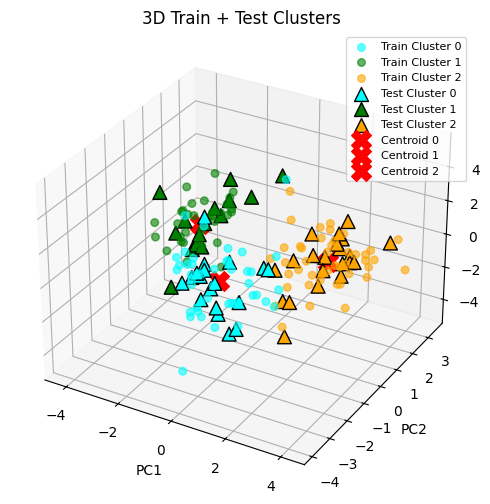

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

colors = ['cyan', 'green', 'orange']

# --- Plot training points ---
for cluster in range(kmeans.n_clusters):
    ax.scatter(
        X_train_3D[train_labels==cluster, 0],
        X_train_3D[train_labels==cluster, 1],
        X_train_3D[train_labels==cluster, 2],
        c=colors[cluster],
        label=f"Train Cluster {cluster}",
        s=30,
        alpha=0.6
    )

# --- Plot test points ---
for cluster in range(kmeans.n_clusters):
    ax.scatter(
        X_test_3D[test_labels==cluster, 0],
        X_test_3D[test_labels==cluster, 1],
        X_test_3D[test_labels==cluster, 2],
        c=colors[cluster],
        label=f"Test Cluster {cluster}",
        s=100,
        edgecolor='black',
        marker='^',
        alpha=1.0
    )

# plot centroids
for i, c in enumerate(kmeans.centroids):
    ax.scatter(c[0], c[1], c[2], c='red', s=200, marker='X', label=f"Centroid {i}")


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("3D Train + Test Clusters")
ax.legend(loc='best', fontsize=8)
plt.show()

# Fit using Kmeans provided by scikit-learn


In [ ]:
from sklearn.cluster import KMeans

kmeans_inbuilt = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init to avoid warning
kmeans_inbuilt.fit(X_train_3D) # Fit the model

train_labels_inbuilt = kmeans_inbuilt.labels_ # Get training labels from the fitted object
test_labels_inbuilt = kmeans_inbuilt.predict(X_test_3D) # Predict labels for the test set
centroids_inbuilt = kmeans_inbuilt.cluster_centers_ # Get centroids from the fitted object


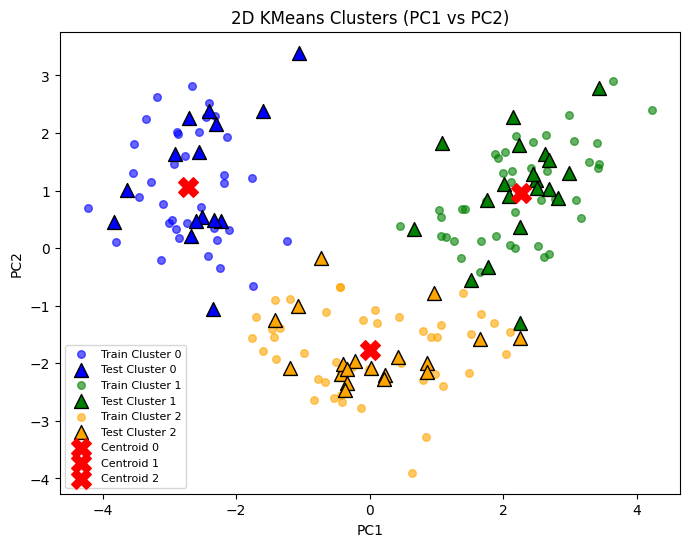

In [ ]:


# visualization in 2D
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'orange']

for cluster in range(n_clusters):
    plt.scatter(
        X_train_3D[train_labels_inbuilt==cluster, 0], # Use train_labels_inbuilt here
        X_train_3D[train_labels_inbuilt==cluster, 1], # Use train_labels_inbuilt here
        color=colors[cluster],
        alpha=0.6,
        label=f"Train Cluster {cluster}",
        s=30
    )

    plt.scatter(
        X_test_3D[test_labels_inbuilt==cluster, 0], # Use test_labels_inbuilt here
        X_test_3D[test_labels_inbuilt==cluster, 1], # Use test_labels_inbuilt here
        color=colors[cluster],
        edgecolor='black',
        marker='^',
        s=100,
        label=f"Test Cluster {cluster}"
    )

# Plot centroids
for i, c in enumerate(centroids_inbuilt):
    plt.scatter(c[0], c[1], c='red', s=200, marker='X', label=f"Centroid {i}")


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D KMeans Clusters (PC1 vs PC2)")
plt.legend(loc='best', fontsize=8)
plt.show()

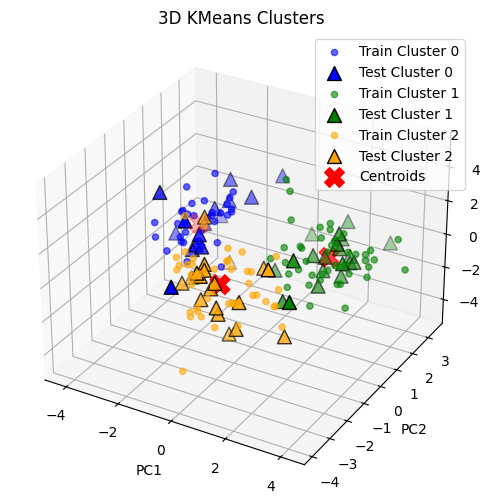

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(n_clusters):
    ax.scatter(
        X_train_3D[train_labels_inbuilt==cluster, 0],
        X_train_3D[train_labels_inbuilt==cluster, 1],
        X_train_3D[train_labels_inbuilt==cluster, 2],
        color=colors[cluster],
        alpha=0.6,
        label=f"Train Cluster {cluster}"
    )
    ax.scatter(
        X_test_3D[test_labels_inbuilt==cluster, 0],
        X_test_3D[test_labels_inbuilt==cluster, 1],
        X_test_3D[test_labels_inbuilt==cluster, 2],
        color=colors[cluster],
        edgecolor='black',
        marker='^',
        s=100,
        label=f"Test Cluster {cluster}"
    )

# Plot centroids
ax.scatter(
    centroids_inbuilt[:,0], centroids_inbuilt[:,1], centroids_inbuilt[:,2],
    color='red', s=200, marker='X', label='Centroids'
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D KMeans Clusters")
ax.legend(loc='best')
plt.show()


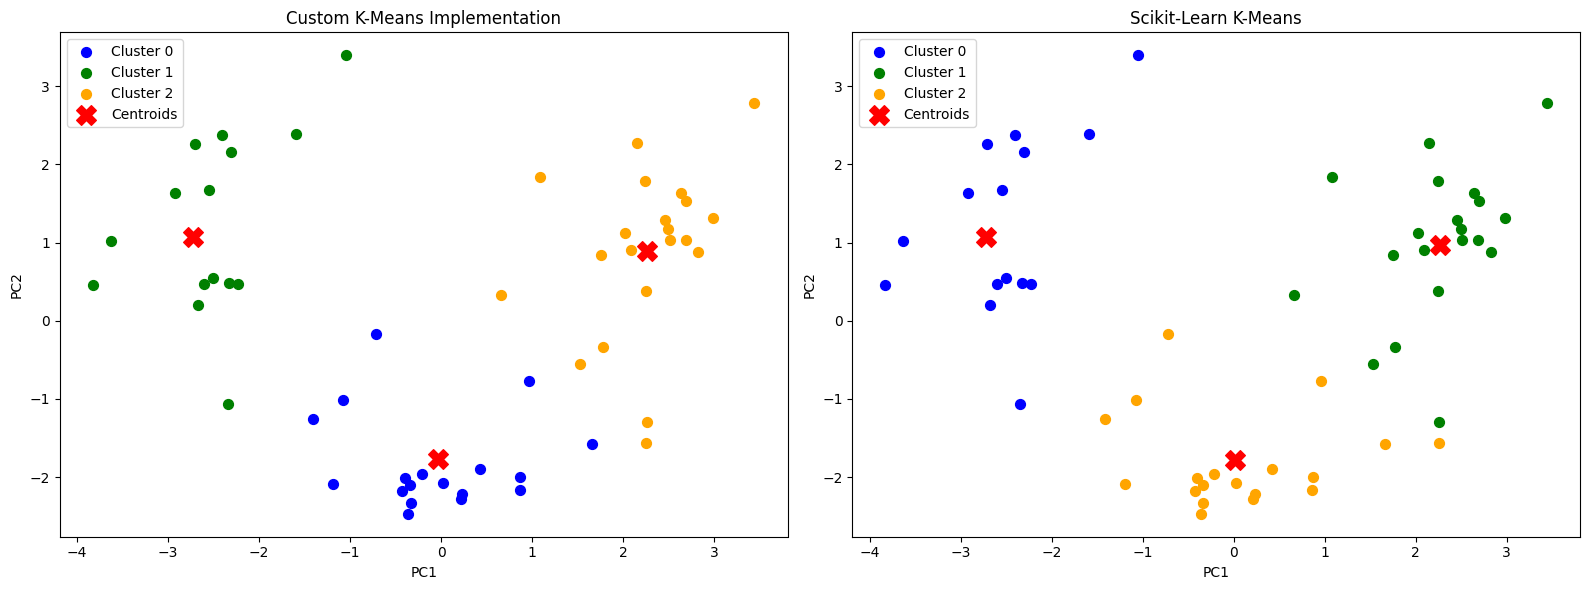

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Our implementation
for cluster in range(3):
    ax1.scatter(
        X_test_3D[test_labels == cluster, 0],
        X_test_3D[test_labels == cluster, 1],
        color=colors[cluster],
        label=f"Cluster {cluster}",
        s=50
    )
ax1.scatter(centroids[:, 0], centroids[:, 1],
           c='red', s=200, marker='X', label='Centroids')
ax1.set_title("Custom K-Means Implementation")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend()

# Scikit-learn implementation
for cluster in range(3):
    ax2.scatter(
        X_test_3D[test_labels_inbuilt == cluster, 0],
        X_test_3D[test_labels_inbuilt == cluster, 1],
        color=colors[cluster],
        label=f"Cluster {cluster}",
        s=50
    )
ax2.scatter(centroids_inbuilt[:, 0], centroids_inbuilt[:, 1],
           c='red', s=200, marker='X', label='Centroids')
ax2.set_title("Scikit-Learn K-Means")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate WCSS (Inertia) for both implementations
def calculate_wcss(X, labels, centroids):
    wcss = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - centroids[i])**2)
    return wcss

custom_wcss = calculate_wcss(X_test_3D, test_labels, centroids)
sklearn_wcss = kmeans_inbuilt.inertia_

print(f"Custom K-Means WCSS: {custom_wcss:.4f}")
print(f"Scikit-Learn WCSS: {sklearn_wcss:.4f}")

Custom K-Means WCSS: 138.5452
Scikit-Learn WCSS: 361.2085
